# BEE 4750 Homework 4: Linear Programming and Capacity Expansion

**Name**:

**ID**:

> **Due Date**
>
> Thursday, 11/07/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to formulate and solve a resource allocation
    problem using linear programming.
-   Problem 2 asks you to formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   Problem 3 (5750 only) asks you to add a CO<sub>2</sub> constraint to
    the capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [78]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/github/Cornell/BEE-5750/hw4-am3366_3`


In [79]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 50/60 Points)

### Problem 1 (20 points)

A farmer has access to a pesticide which can be used on corn, soybeans,
and wheat fields, and costs \$70/ha-yr to apply. The crop yields the
farmer can obtain following crop yields by applying varying rates of
pesticides to the field are shown in
<a href="#tbl-yields" class="quarto-xref">Table 1</a>.

| Application Rate (kg/ha) | Soybean (kg/ha) | Wheat (kg/ha) | Corn (kg/ha) |
|:------------------------:|:---------------:|:-------------:|:------------:|
|            0             |      2900       |     3500      |     5900     |
|            1             |      3800       |     4100      |     6700     |
|            2             |      4400       |     4200      |     7900     |

Table 1: Crop yields from applying varying pesticide rates for Problem
1.

The costs of production, *excluding pesticides*, for each crop, and
selling prices, are shown in
<a href="#tbl-costs" class="quarto-xref">Table 2</a>.

|   Crop   | Production Cost (\$/ha-yr) | Selling Price (\$/kg) |
|:--------:|:--------------------------:|:---------------------:|
| Soybeans |            350             |         0.36          |
|  Wheat   |            280             |         0.27          |
|   Corn   |            390             |         0.22          |

Table 2: Costs of crop production, excluding pesticides, and selling
prices for each crop.

Recently, environmental authorities have declared that farms cannot have
an *average* application rate on soybeans, wheat, and corn which exceeds
0.8, 0.7, and 0.6 kg/ha, respectively. The farmer has asked you for
advice on how they should plant crops and apply pesticides to maximize
profits over 130 total ha while remaining in regulatory compliance if
demand for each crop (which is the maximum the market would buy) this
year is 250,000 kg?

**In this problem**:

-   Formulate a linear program for this resource allocation problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations). **Tip: Make sure that all of your constraints are
    linear**.
-   Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?
-   The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.



### <font color='blue'> **SOLUTION - Problem 1** </font>

<font color='blue'> *Step 1: Formulate a linear program for this resource allocation problem, including clear definitions of decision variable(s) (including units), objective function(s), and constraint(s) (make sure to explain functions and constraints with any needed derivations and explanations).* </font>

Decision variables: 

Let $s_0, s_1, s_2$ be the number of ha dedicated to growing soybean under the pesticide application rates 0, 1, and 2 respectively. Similarly, let $w_0, w_1, w_2$ be the number of ha dedicated to growing wheat under the different pesticide application rates and let $c_0, c_1, c_2$ be the number of ha dedicated to growing corn under the different pesticide application rates.

Objective function:
$$max. Profit = Total Revenue - Total Cost$$
$$= revenue - cost_{production} - cost_{application}$$
$$
=
\begin{bmatrix}
2900 s_0 & 3500 w_0 & 5900 c_0\\
3800 s_1 & 4100 w_1 & 6700 c_1\\
4400 s_2 & 4200 w_2 & 7900 c_2
\end{bmatrix}
\begin{bmatrix}
0.36\\
0.27\\
0.22
\end{bmatrix}
-
\begin{bmatrix}
s_0 & w_0 & c_0\\
s_1 & w_1 & c_1\\
s_2 & w_2 & c_2
\end{bmatrix}
\begin{bmatrix}
350\\
280\\
390
\end{bmatrix}
-
\begin{bmatrix}
0 \times 70 & 1 \times 70 & 2 \times 70
\end{bmatrix}
\begin{bmatrix}
s_0 & w_0 & c_0\\
s_1 & w_1 & c_1\\
s_2 & w_2 & c_2
\end{bmatrix}
$$

$$revenue: 0.36 \times (2900s_0 + 3800s_1 + 4400s_2) + 0.27 \times (3500w_0 + 4100w_1 + 4200w_2) + 0.22 \times (5900c_0 + 6700c_1 + 7900c_2)$$
$$cost_{production}: - 350 \times (s_0 + s_1 + s_2) - 280 \times (w_0 + w_1 + w_2) - 390 \times (c_0 + c_1 + c_2)$$
$$cost_{application}: 0 \times 70 \times (s_0 + w_0 + c_0) + 1 \times 70 \times (s_1 + w_1 + c_1) + 2 \times 70 \times (s_2 + w_2 + c_2)$$
$$\textrm{Profit from Soybean: } (0.36 \times 2900 - 350)s_0 + (0.36 \times 3800 - 350 - 70)s_1 + (0.36 \times 4400 - 350 - 140)s_2$$
$$\textrm{Profit from Wheat: } (0.27 \times 3500 - 280)w_0 + (0.27 \times 4100 - 280 - 70)w_1 + (0.27 \times 4200 - 280 - 140)w_2$$
$$\textrm{Profit from Corn: } (0.22 \times 5900 - 390)c_0 + (0.22 \times 6700 - 390 - 70)c_1 + (0.22 \times 7900 - 390 - 140)c_2$$
$$\textrm{Profit } = 694s_0 + 948s_1 + 1094s_2 + 665w_0 + 757w_1 + 714w_2 + 908c_0 + 1014c_1 + 1208c_2$$

Constraints: 
- Non-negativity: $s_0, s_1, s_2, w_0, w_1, w_2, c_0, c_1, c_2 \geq 0$
- Maximum average application rate for soybeans: 
$$\frac{s_0 \times 0 + s_1 \times 1 + s_2 \times 2}{s_0 + s_1 + s_2} \leq 0.8$$
$$\Rightarrow s_1 + 2s_2 \leq 0.8s_0 + 0.8 s_1 + 0.8s_2$$
$$\Rightarrow -0.8s_0 + 0.2s_1 + 1.2s_2 \leq 0$$
- Maximum average application rate for wheat: 
$$\frac{w_0 \times 0 + w_1 \times 1 + w_2 \times 2}{w_0 + w_1 + w_2} \leq 0.7$$
$$\Rightarrow w_1 + 2w_2 \leq 0.7w_0 + 0.7w_1 + 0.7w_2$$
$$\Rightarrow -0.7w_0 + 0.3w_1 + 1.3w_2 \leq 0$$
- Maximum average application rate for corn:
$$\frac{c_0 \times 0 + c_1 \times 1 + c_2 \times 2}{c_0 + c_1 + c_2} \leq 0.6$$
$$\Rightarrow c_1 + 2c_2 \leq 0.6c_0 + 0.6c_1 + 0.6c_2$$
$$\Rightarrow -0.6c_0 + 0.4c_1 + 1.4c_2 \leq 0$$
- Amount of land: $s_0 + s_1 + s_2 + w_0 + w_1 + w_2 + c_0 + c_1 + c_2 <= 130$
- Maximum demand of soybeans: $2900s_0 + 3800s_1 + 4400s_2 \leq 250,000$
- Maximum demand of wheat:  $3500w_0 + 4100w_1 + 4200w_2 \leq 250,000$
- Maximum demand of corn: $5900c_0 + 6700c_1 + 7900c_2 \leq 250,000$

<font color='blue'> *Step 2: Implement the program in `JuMP.jl` and find the solution. How many
    ha should the farmer dedicate to each crop and with what pesticide
    application rate(s)? How much profit will the farmer expect to make?* </font>

The JuMP model is implemented below and is defined by the objective function and constraints from Part 1. Running the model gives the following output:

$$value.(S) = [13.812154696132604, 55.24861878453038, 0.0]$$
$$value.(W) = [6.7433064173395625, 15.734381640458977, 0.0]$$
$$value.(C) = [26.92307692307692, 0.0, 11.538461538461547]$$
$$objective.value(crop.model) = 116741.16702082448$$

**Thus, the farmer can expect to make $116,741.17 in profit and should dedicate their land to crops and pesticides as follows:**
- Soybeans, 0 application ($s_0 = S[1]$): 13.81 ha 
- Soybeans, 1 application ($s_1 = S[2]$): 55.25 ha
- Soybeans, 2 application ($s_2 = S[3]$): 0 ha
- Wheat, 0 application ($w_0 = W[1]$): 6.74 ha
- Wheat, 1 application ($w_1 = W[2]$): 15.73 ha
- Wheat, 2 application ($w_2 = W[3]$): 0 ha
- Corn, 0 application ($c_0 = C[1]$): 26.92 ha
- Corn, 1 application ($c_1 = C[2]$): 0 ha
- Corn, 2 application ($c_2 = C[3]$): 11.54 ha

In [80]:
crop_model = Model(HiGHS.Optimizer) # initialize model object
@variable(crop_model, S[1:3] >= 0) # non-negativity constraints
@variable(crop_model, W[1:3] >= 0) # non-negativity constraints
@variable(crop_model, C[1:3] >= 0) # non-negativity constraints

@objective(crop_model, Max, [694; 948; 1094]' * S + [665; 757; 714]' * W + [908; 1014; 1208]' * C)

kg_soybean = [2900; 3800; 4400]; kg_wheat = [3500; 4100; 4200]; kg_corn = [5900; 6700; 7900]

@constraint(crop_model, application_soybeans, [-0.8; 0.2; 1.2]' * S <= 0) 
@constraint(crop_model, application_wheat, [-0.7; 0.3; 1.3]' * W <= 0)
@constraint(crop_model, application_corn, [-0.6; 0.4; 1.4]' * C <= 0) 
@constraint(crop_model, amt_land, sum(S) + sum(W) + sum(C) <= 130)
@constraint(crop_model, demand_soybeans, kg_soybean' * S <= 250000)
@constraint(crop_model, demand_wheat, kg_wheat' * W <= 250000)
@constraint(crop_model, demand_corn, kg_corn' * C <= 250000)

# print(crop_model)

demand_corn : 5900 C[1] + 6700 C[2] + 7900 C[3] ≤ 250000

In [81]:
optimize!(crop_model)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-01, 8e+03]
  Cost   [7e+02, 1e+03]
  Bound  [0e+00, 0e+00]
  RHS    [1e+02, 2e+05]
Presolving model
7 rows, 9 cols, 27 nonzeros  0s
7 rows, 9 cols, 27 nonzeros  0s
Presolve : Reductions: rows 7(-0); columns 9(-0); elements 27(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.8170297740e+02 Ph1: 7(28.3601); Du: 9(181.703) 0s
          7     1.1674116702e+05 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.1674116702e+05
HiGHS run time      :          0.00


In [82]:
@show value.(S);
@show value.(W);
@show value.(C);
@show objective_value(crop_model);

value.(S) = [13.812154696132604, 55.24861878453038, 0.0]
value.(W) = [6.7433064173395625, 15.734381640458977, 0.0]
value.(C) = [26.92307692307692, 0.0, 11.538461538461547]
objective_value(crop_model) = 116741.16702082448


<font color='blue'> *Step 3: The farmer has an opportunity to buy an extra 10 ha of land. How
    much extra profit would this land be worth to the farmer? Discuss
    why this value makes sense and whether you would recommend the
    farmer should make the purchase.* </font>

Recall that the shadow price represents how the output of our objective function would change if we relaxed a given constraint by one unit. From the code below, we see that relaxing our amount of land by one unit, i.e. increasing our land by 1 ha, would result in $\$729.4$ of profit. Multiplying this by 10, we get that an additional 10 ha of land would be worth $\$7,294$ of additional profit. 

This value makes sense because when we evaluate the shadow prices of the other constraints, only the shadow price of wheat equals 0. In other words, all of the constraints are binding except wheat. Because the only non-binding constraint on the crops is wheat and because the constraint on the application rate for wheat is binding, we can extrapolate that the strategy of crop growth to maximize profit will continue as is, i.e. growing soybeans and corn with the same application rates. Thus the shadow price of the amount of land represents our marginal profit. 

In [83]:
@show shadow_price(application_soybeans);
@show shadow_price(application_wheat);
@show shadow_price(application_corn);
@show shadow_price(demand_soybeans);
@show shadow_price(demand_wheat);
@show shadow_price(demand_corn);

@show shadow_price(amt_land); 
@show shadow_price(amt_land)*10; 

shadow_price(application_soybeans) = 212.28176795580106
shadow_price(application_wheat) = 92.00000000000004
shadow_price(application_corn) = 108.67692307692309
shadow_price(demand_soybeans) = 0.046353591160221
shadow_price(demand_wheat) = -0.0
shadow_price(demand_corn) = 0.04132307692307692
shadow_price(amt_land) = 729.4
shadow_price(amt_land) * 10 = 7294.0


### Problem 2 (30 points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

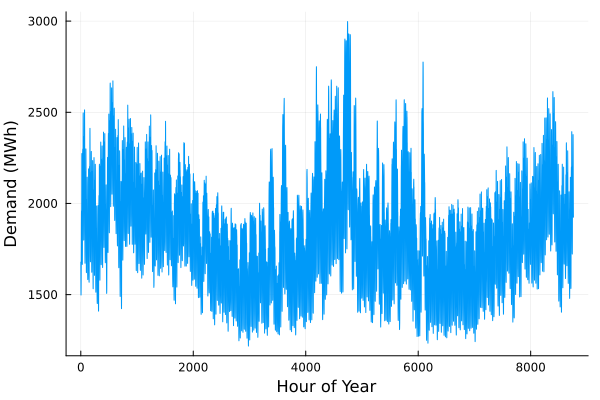

In [84]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data, shown in
<a href="#tbl-generators" class="quarto-xref">Table 3</a>. This data
includes fixed costs (\$/MW installed), variable costs (\$/MWh
generated), and CO<sub>2</sub> emissions intensity (tCO<sub>2</sub>/MWh
generated).

In [85]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

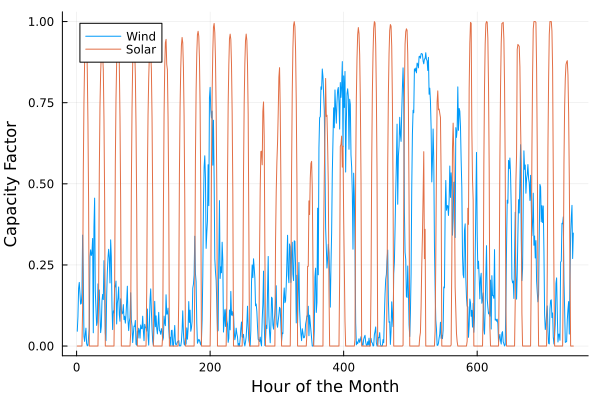

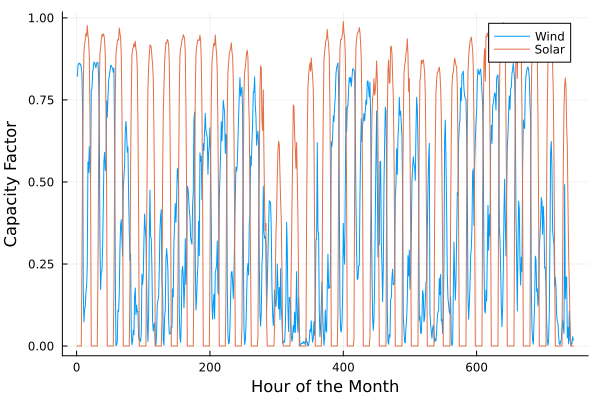

In [86]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley County, NY, which currently has no existing
electrical generation infrastructure. The utility can build any of the
following plant types: geothermal, coal, natural gas combined cycle gas
turbine (CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$10,000/MWh.

**In this problem**:

-   Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).
-   Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?
-   What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 1.5? Do these results make sense given the generator
    data?
-   Make a plot of the electricity price in each hour. Discuss any
    trends that you see.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision! If your number is on a different order of magnitude and you
> want to round to a certain number of significant digits, you can use
> `round(x; sigdigits=n)`.

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

### <font color='blue'> **SOLUTION - Problem 2** </font>

<font color='blue'> *Step 1: Formulate a linear program for this capacity expansion problem,
    including clear definitions of decision variable(s) (including
    units), objective function(s), and constraint(s) (make sure to
    explain functions and constraints with any needed derivations and
    explanations).* </font>

Decision variables:

Let $x_g$ to be the installed capacity in MW for $g \in G$, let $y_{g,t}$ be the production in MWh from $g \in G, t \in T$, and let $NSE_t$ be the non-served energy in MWh in $t \in T$, where $g \in G$ is the generator type and $t \in T$ is the time period. 

Objective function: 
$$min. Total Cost = cost_{investment} + cost_{operating} + cost_{NSE}$$
$$= \sum_{g \in G}FixedCost_g \times x_g + \sum_{t \in T} \sum_{g \in G}VarCost_g \times y_{g,t} + \sum_{t \in T} NSECost \times NSE_t$$

Constraints: 
- Minimum demand: $\sum_{g \in G} y_{g,t} + NSE_t \geq d_t, \forall t \in T$
- Maximum capacity: $y_{g,t} \leq x_g \times c_{g,t}, \forall g \in G, \forall t \in T$ where $c_{g,t}$ is the capacity factor for $g \in G, t \in T$, 
- Non-negativity: $x_g, y_{g,t}, NSE_t \geq 0, \forall g \in G, \forall t \in T$

<font color='blue'> *Step 2: Implement your linear program in `JuMP.jl`. Find the optimal
    solution. How much should the utility build of each type of
    generating plant? What will the total cost be? How much energy will
    be non-served?* </font>

The linear program is implemented below and is adapted from the code from Lecture 13. Here we additionally account for hourly capacity in the constraints by creating a matrix of the hourly capacity for each generator type and then multiplying the installed capacity $x_g$ by hourly capacity factors $c_{g,t}$. Note that geothermal, coal, NG_CCGT, and NG_CT have fixed capacities of 85%, 100%, 100%, and 100% as given in the problem statement. Meanwhile, the capacity factors of wind and solar change hourly and are given in *cap_factor*. 

**We find that the utility should build 0 MW of geothermal, 0 MW of coal, 1658.45 MW of NG CCGT, 879.75 MW of NG CT, 484.95 MW of wind, and 1957.64 MW of solar. The total cost would be $654,584,870.4. The amount of energy that would be non-served is 2768.68 MWh.**

In [87]:
c = DataFrame(Geothermal=0.85, Coal=1, NG_CCGT=1, NG_CT=1, Wind=cap_factor[!, "Wind"], Solar=cap_factor[!, "Solar"])
c = Matrix(c)';

In [88]:
# define sets
G = 1:nrow(gens[1:end, :])
T = 1:nrow(demand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    x[g in G] >= 0  # installed capacity
    y[g in G, t in T] >= 0  # generated power
    NSE[t in T] >= 0  # non-served electricity
end)
@objective(gencap, Min, 
    sum(gens[G, :FixedCost] .* x) + sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= demand.Demand[t])
@constraint(gencap, availability[g in G, t in T], y[g, t] <= x[g] * c[g,t])
# print(gencap)

2-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},2,...} with index sets:
    Dimension 1, 1:6
    Dimension 2, 1:8760
And data, a 6×8760 Matrix{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 availability[1,1] : -0.85 x[1] + y[1,1] ≤ 0         …  availability[1,8760] : -0.85 x[1] + y[1,8760] ≤ 0
 availability[2,1] : -x[2] + y[2,1] ≤ 0                 availability[2,8760] : -x[2] + y[2,8760] ≤ 0
 availability[3,1] : -x[3] + y[3,1] ≤ 0                 availability[3,8760] : -x[3] + y[3,8760] ≤ 0
 availability[4,1] : -x[4] + y[4,1] ≤ 0                 availability[4,8760] : -x[4] + y[4,8760] ≤ 0
 availability[5,1] : -0.045622487 x[5] + y[5,1] ≤ 0     availability[5,8760] : -0.208157554 x[5] + y[5,8760] ≤ 0
 availability[6,1] : y[6,1] ≤ 0                 

In [89]:
optimize!(gencap)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [5e-05, 1e+00]
  Cost   [2e+01, 4e+05]
  Bound  [0e+00, 0e+00]
  RHS    [1e+03, 3e+03]
Presolving model
56856 rows, 56862 cols, 153048 nonzeros  0s
56853 rows, 56859 cols, 153042 nonzeros  0s
Presolve : Reductions: rows 56853(-4467); columns 56859(-4467); elements 153042(-8934)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.1747e+06) 0s
      42008     6.5458487038e+08 Pr: 0(0); Du: 0(2.80224e-10) 3s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 42008
Objective value     :  6.5458487038e+08
HiGHS run time      :          2.65


In [90]:
@show value.(x)

value.(x) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
   -0.0
    0.0
 1658.4514133074133
  879.7538120149645
  484.946167110047
 1957.6424239086684


1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
   -0.0
    0.0
 1658.4514133074133
  879.7538120149645
  484.946167110047
 1957.6424239086684

In [91]:
# @show value.(NSE);

In [92]:
sum(value.(NSE))

256.83377442738583

In [93]:
@show objective_value(gencap)

objective_value(gencap) = 6.545848703815409e8


6.545848703815409e8

In [94]:
# @show shadow_price.(availability);

<font color='blue'> *Step 3: What fraction of annual generation does each plant type produce? How
    does this compare to the breakdown of built capacity that you found
    in Problem 2.2? Do these results make sense given the generator
    data?* </font>

Summing hourly production in MWh over time within each generator type, we get that the generation in MWh per year is 0 MWh of geothermal, 0 MW of coal, 8,656,647.08 MWh of NG CCGT, 449,375.89 MWh of NG CT, 1,427,204.35 MWh of wind, and 5,834,421.74 MWh of solar. 

Since the total MWh produced is 16367649.06, the fraction of annual generation that each plant type produces is as follows: 0 geothermal, 0 coal, 0.528 NG CCGT, 0.027 NG CT, 0.087 wind, 0.356 solar. 

Given that NG CCGT has the largest generator capacity and costs less than most of the other generator types (i.e. geothermal, coal, wind), it makes sense that NG CCGT contributes the largest fraction of annual generation. Meanwhile solar has the second largest fraction of annual generation, which also makes sense given that it  has the second largest generator capacity and is the cheapest generator type. On the other hand, coal and geothermal are the most expensive generator types by an order of magnitude so it also makes sense that they would have 0 annual generation. 

In [95]:
# @show value.(y);

In [96]:
value.(y.data);

In [97]:
y_matrix = value.(y.data);

In [98]:
sum(y_matrix, dims=2)

6×1 Matrix{Float64}:
      0.0
      0.0
      8.656647084004143e6
 449375.8891095476
      1.4272043521321972e6
      5.834421740979558e6

<font color='blue'> *Step 4: Make a plot of the electricity price in each hour. Discuss any
    trends that you see.* </font>

See below for a plot of the electricity price per hour. Observe that there are intermittent spikes in electricity price, which represent times when non-served energy is bought. 

In [99]:
# hourly_electricity_data = gens[G, :VarCost]' * value.(y.data) + NSECost * value.(NSE)'
# @show shadow_price.(load);

In [100]:
load_data = abs.(shadow_price.(load).data);

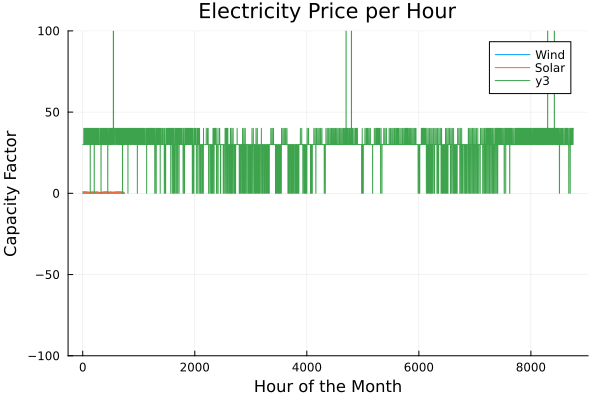

In [101]:
plot!(load_data, title="Electricity Price per Hour", ylim=(-100, 100))

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

**In this problem**:

-   Reformulate your linear program from Problem 2 with any necessary
    changes to capture the CO<sub>2</sub> limit.
-   Implement the new optimization problem and find the optimal
    solution. How much should the utility build of each type of
    generating plant? What is different from your plan from Problem 1?
    Do these changes make sense?
-   What would the value to the utility be of allowing it to emit an
    additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

### <font color='blue'> **SOLUTION - Problem 3** </font>

<font color='blue'> *Step 1: Reformulate your linear program from Problem 2 with any necessary
    changes to capture the CO<sub>2</sub> limit.* </font>

Decision variables:

Let $x_g$ to be the installed capacity in MW for $g \in G$, let $y_{g,t}$ be the production in MWh from $g \in G, t \in T$, and let $NSE_t$ be the non-served energy in MWh in $t \in T$, where $g \in G$ is the generator type and $t \in T$ is the time period.

Objective function: 
$$min. Total Cost = cost_{investment} + cost_{operating} + cost_{NSE}$$
$$= \sum_{g \in G}FixedCost_g \times x_g + \sum_{t \in T} \sum_{g \in G}VarCost_g \times y_{g,t} + \sum_{t \in T} NSECost \times NSE_t$$

Constraints: 
- Minimum demand: $\sum_{g \in G} y_{g,t} + NSE_t \geq d_t, \forall t \in T$
- Maximum capacity: $y_{g,t} \leq x_g \times c_{g,t}, \forall g \in G, \forall t \in T$ where $c_{g,t}$ is the capacity factor for $g \in G, t \in T$, 
- Non-negativity: $x_g, y_{g,t}, NSE_t \geq 0, \forall g \in G, \forall t \in T$
- **Maximum CO2 emissions:** $\sum_{g \in G} y_{g,t} \times e_g \leq 1.5, \forall g \in G, \forall t \in T$ where $e_g$ is the emissions rate for $g \in G$

<font color='blue'> *Step 2: Implement the new optimization problem and find the optimal
    solution. How much should the utility build of each type of
    generating plant? What is different from your plan from Problem 2?
    Do these changes make sense?* </font>

We implement the linear program as we did in problem 2, with the additional constraing capping total CO2 emissions per hour at 1.5. We find that the optimal solution here has a cost of $1,377,697,164.26 and recommends building 2863.7 MW of geothermal, 0 MW of coal, 3.49 MW of NG CCGT, 0 MW of NG CT, 251.21 MW of wind, and 545.63 MW of solar. 

On the other hand, recall that Problem 2 recommended building 0 MW of geothermal, 0 MW of coal, 1658.45 MW of NG CCGT, 879.75 MW of NG CT, 484.95 MW of wind, and 1957.64 MW of solar. 

Since the only change in this model is that there is a constraint capping the maximum CO2 emissions at 1.5, it makes sense that the energy sources with the highest CO2 emissions would decrease and the energy sources with the lowest CO2 emissions would increase. In other words, that natural gas allocations would decrease while geothermal, solar, and wind energy allocations would increase.


In [102]:
# define sets
G = 1:nrow(gens[1:end, :])
T = 1:nrow(demand)
NSECost = 10000

gencap = Model(HiGHS.Optimizer)
# define variables
@variables(gencap, begin
    x[g in G] >= 0  # installed capacity
    y[g in G, t in T] >= 0  # generated power
    NSE[t in T] >= 0  # non-served electricity
end)
@objective(gencap, Min, 
    sum(gens[G, :FixedCost] .* x) + sum(gens[G, :VarCost] .* sum(y[:, t] for t in T)) + NSECost * sum(NSE)
)
@constraint(gencap, load[t in T], sum(y[:, t]) + NSE[t] >= demand.Demand[t])
@constraint(gencap, availability[g in G, t in T], y[g, t] <= x[g] * c[g,t])
@constraint(gencap, max_emissions, sum(gens[G, :Emissions] .* x) <= 1.5)
# print(gencap);

max_emissions : x[2] + 0.43 x[3] + 0.55 x[4] ≤ 1.5

In [103]:
optimize!(gencap)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [5e-05, 1e+00]
  Cost   [2e+01, 4e+05]
  Bound  [0e+00, 0e+00]
  RHS    [2e+00, 3e+03]
Presolving model
56857 rows, 56862 cols, 153051 nonzeros  0s
56854 rows, 56859 cols, 153045 nonzeros  0s
Presolve : Reductions: rows 56854(-4467); columns 56859(-4467); elements 153045(-8934)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.25594e+06) 0s
      23127     1.3776971643e+09 Pr: 0(0); Du: 0(4.45316e-10) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 23127
Objective value     :  1.3776971643e+09
HiGHS run time      :          0.40


In [104]:
@show objective_value(gencap)

objective_value(gencap) = 1.37769716426191e9


1.37769716426191e9

In [105]:
@show value.(x)

value.(x) = 1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
 2863.69926818533
    0.0
    3.488372093023256
    0.0
  251.20746023134632
  545.6275148286037


1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:6
And data, a 6-element Vector{Float64}:
 2863.69926818533
    0.0
    3.488372093023256
    0.0
  251.20746023134632
  545.6275148286037

In [106]:
# @show value.(load)

In [107]:
# @show value.(availability);

In [108]:
# @show value.(NSE)

<font color='blue'> *Step 3: What would the value to the utility be of allowing it to emit an
    additional 1000 tCO<sub>2</sub>/yr? An additional 5000?* </font>

Taking the shadow price of the CO2 constraint and multiplying it by 1,000, we get that the value to the utility of allowing it to emit an additional 1000 tCO<sub>2</sub>/yr would be $-1,036,515,732. 

Taking the shadow price of the CO2 constraint and multiplying it by 5,000, we get that the value to the utility of allowing it to emit an additional 5000 tCO<sub>2</sub>/yr would be $-5,182,578,659.

In [109]:
@show shadow_price(max_emissions)

shadow_price(max_emissions) = -1.0365157318741438e6


-1.0365157318741438e6

In [110]:
@show shadow_price(max_emissions) * 1000

shadow_price(max_emissions) * 1000 = -1.0365157318741438e9


-1.0365157318741438e9

In [111]:
@show shadow_price(max_emissions) * 5000

shadow_price(max_emissions) * 5000 = -5.182578659370719e9


-5.182578659370719e9

## References

List any external references consulted, including classmates.